In [71]:
import pandas as pd
import numpy as np

In [72]:
# read csv in to file
credits = pd.read_csv("credits.csv")
movies = pd.read_csv("score_preprocessing.csv")

tempoarary code

In [73]:
def log(data):
    return np.log1p(data)

In [74]:
def normalize(imput_list):
    movies_array = np.array(imput_list)
    # Calculate min and max values
    min_val = np.min(movies_array)
    max_val = np.max(movies_array)

    # Perform Max-Min normalization
    normalized_data = (movies_array - min_val) / (max_val - min_val)
    return normalized_data

In [75]:
#log_imdb_vote = log(movies["imdb_votes"])
#log_tmdb_popularity = log(movies["tmdb_popularity"])
#nor_imdb_score = normalize(movies["imdb_score"])
#nor_tmdb_score = normalize(movies["tmdb_score"])

#movies["imdb_score"] = nor_imdb_score
#movies["imdb_vote"] = log_imdb_vote
#movies["tmdb_popularity"] = log_tmdb_popularity
#movies["tmdb_score"] = nor_tmdb_score

endif

In [76]:
# create a director,actor dictionary with name as key, vlaue in the form [list of movie, number of movies acted ,average rating] and output as a new csv

MOVIE_ID = 0
MOVIE_COUNT = 1
SUM_MOVIE_SCORE = 2
SUM_POPULARITY_SCORE = 3
AVG_SCORE = 4
AVG_POP = 5

actors_dict = {}
directors_dict = {}
movies_dict = {}  # value format [score,popularity,actors,directors]

for index, data in movies.iterrows():
    if(data["id"] not in movies_dict.keys()):
        movies_dict[data["id"]] = [((data["imdb_score"] + data["tmdb_score"])/2), data["weighted_average_popularity"],[],[]]

for index, data in credits.iterrows():
    if(data["id"][1] == "s") :
        continue
    if(data["role"] == "ACTOR"):
        movies_dict[data["id"]][2].append(data["name"])
        if(data["name"] not in actors_dict.keys()):
            actors_dict[data["name"]] = [[data["id"]],1,movies_dict[data["id"]][0],movies_dict[data["id"]][1] ,0,0]
        else:
            actors_dict[data["name"]][MOVIE_COUNT] += 1
            actors_dict[data["name"]][SUM_MOVIE_SCORE] = actors_dict[data["name"]][SUM_MOVIE_SCORE] + movies_dict[data["id"]][0]
            actors_dict[data["name"]][SUM_POPULARITY_SCORE] += movies_dict[data["id"]][1]
            actors_dict[data["name"]][MOVIE_ID].append(data["id"])
    else:
        movies_dict[data["id"]][3].append(data["name"])
        if(data["name"] not in directors_dict.keys()):
            directors_dict[data["name"]] = [[data["id"]],1,movies_dict[data["id"]][0],movies_dict[data["id"]][1] ,0,0]
        else:
            directors_dict[data["name"]][MOVIE_COUNT] += 1
            directors_dict[data["name"]][SUM_MOVIE_SCORE] = directors_dict[data["name"]][SUM_MOVIE_SCORE] + movies_dict[data["id"]][0]
            directors_dict[data["name"]][SUM_POPULARITY_SCORE] += movies_dict[data["id"]][1]
            directors_dict[data["name"]][MOVIE_ID].append(data["id"])
for values in actors_dict.values():
    values[AVG_SCORE] = (values[SUM_MOVIE_SCORE]) / (values[MOVIE_COUNT])
    values[AVG_POP] = (values[SUM_POPULARITY_SCORE]) / (values[MOVIE_COUNT])
for values in directors_dict.values():
    values[AVG_SCORE] = (values[SUM_MOVIE_SCORE]) / (values[MOVIE_COUNT])
    values[AVG_POP] = (values[SUM_POPULARITY_SCORE]) / (values[MOVIE_COUNT])


In [77]:
# Put all the data into csv file
act_df = pd.DataFrame.from_dict(actors_dict)
act_df = act_df.transpose()
# add title to the data
column_titles = ['movie acted', 'num_of_movie',"sum_score" ,"sum_popularity","avg_score","avg_popularity"]  # Replace with desired column titles
act_df.columns = column_titles
act_df.index.name = "name"
act_df.to_csv("actor.csv")

#do exact same thing for director
dir_df = pd.DataFrame.from_dict(directors_dict)
dir_df = dir_df.transpose()
# add title to the data
column_titles = ['movie acted', 'num_of_movie',"sum_score" ,"sum_popularity","avg_score","avg_popularity"]  # Replace with desired column titles
dir_df.columns = column_titles
dir_df.index.name = "name"
dir_df.to_csv("director.csv")

use k mean to determine an actor is popular or not, base on vector (num_of_moviesacted, WA_popularity)

In [78]:
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import itertools

C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

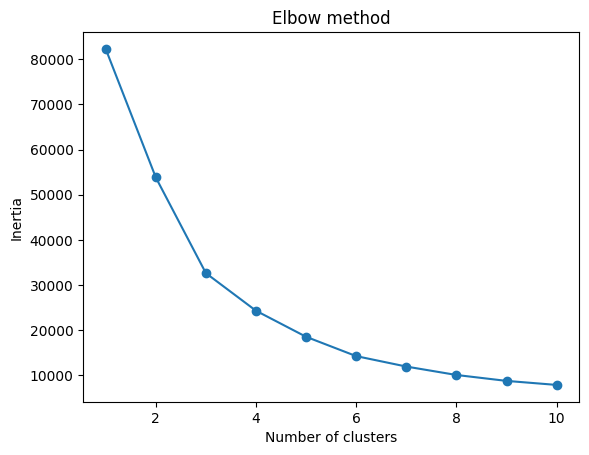

In [79]:
actor_df = pd.read_csv("actor.csv")
data = list(zip(actor_df["num_of_movie"], actor_df["avg_score"], actor_df["avg_popularity"]))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


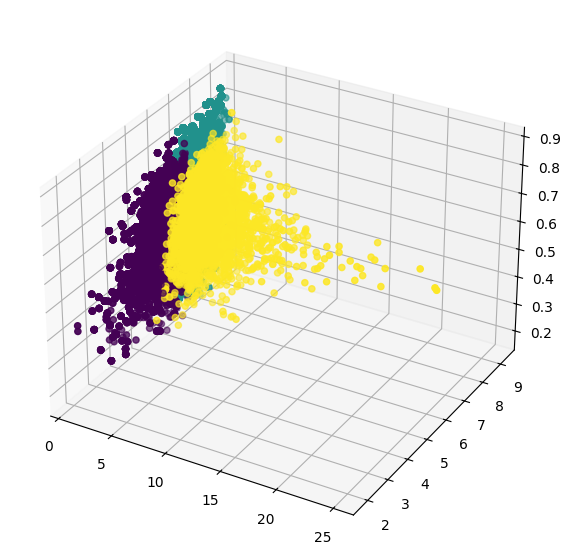

In [80]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
label = kmeans.labels_

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(actor_df["num_of_movie"], actor_df["avg_score"], actor_df["avg_popularity"], c=label)


#plt.scatter(actor_df["num_of_movie"], actor_df["avg_score"], actor_df["avg_popularity"], c=label)
#plt.show()

df = pd.DataFrame({'ClusterLabel': label})
df_comb = pd.concat([actor_df,df], axis=1, join='inner')
df_comb.to_csv('actor.csv', index=False)

C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

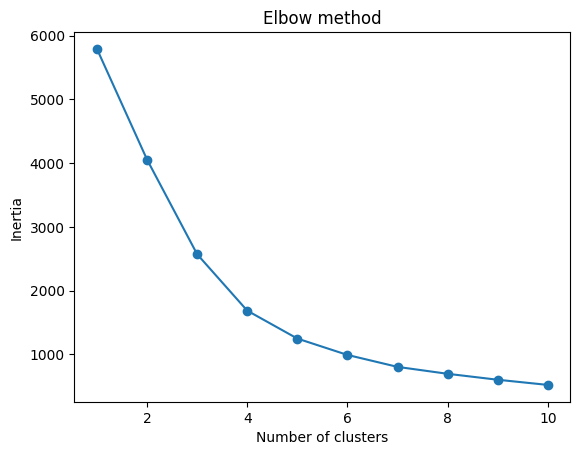

In [81]:
director_df = pd.read_csv("director.csv")
data = list(zip(director_df["num_of_movie"], director_df["avg_score"], director_df["avg_popularity"]))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


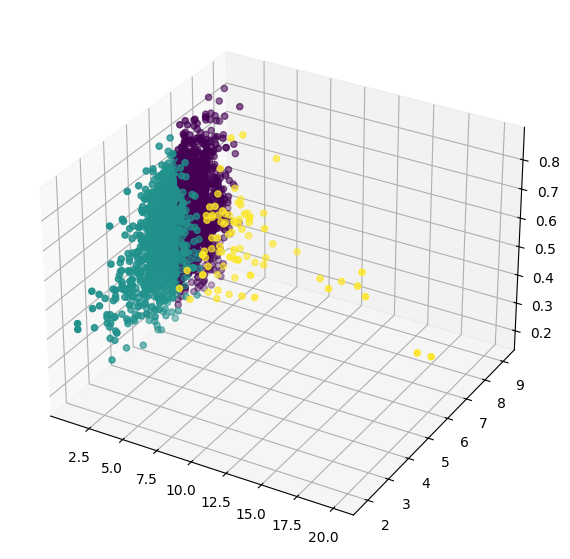

In [82]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
label = kmeans.labels_

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(director_df["num_of_movie"], director_df["avg_score"], director_df["avg_popularity"], c=label)


#plt.scatter(actor_df["num_of_movie"], actor_df["avg_score"], actor_df["avg_popularity"], c=label)
#plt.show()


df = pd.DataFrame({'ClusterLabel': label})
df_comb = pd.concat([director_df,df], axis=1, join='inner')
df_comb.to_csv('director.csv', index=False)

In [83]:
def contain_popular_actor(name,p_actor_dict):
    result = [0,1,2]
    for actor in name:
        result.append(p_actor_dict[actor])
    result.sort()
    result = [len(list(g))-1 for k, g in itertools.groupby((result))]
    #for i in range(len(result)):
        #if result[i] > 0:
            #result[i] = 1
        #else:
            #result[i] = 0
    return result

In [86]:
actor = pd.read_csv("actor.csv")
movie = pd.read_csv("score_preprocessing.csv")
p_movie_dict = {}
p_actor_dict = {}

for index, data in actor.iterrows():
    p_actor_dict[data["name"]] = data["ClusterLabel"]
for id, data in movies_dict.items():
    if(id[1] == 's'):
        continue
    result = contain_popular_actor(data[2],p_actor_dict)
    result.append((data[1])) #data[1] in movie_dict refer to popularity score
    p_movie_dict[id] = result
    
# p_movi_dict is in the format {movie_id:[[0,num_of_actor_w_label0],[1,num_of_actor_w_label1],[2,num_of_actor_w_label2]]}
# use this to determine relationship  
    

#print(p_movie_dict)
movie_popularity = []
high_pop_actor = []
mid_pop_actor = []
low_pop_actor = []
pop_actor = []
for key,item in p_movie_dict.items():
    movie_popularity.append(item[3])
    high_pop_actor.append(item[1])
    mid_pop_actor.append(item[2])
    low_pop_actor.append(item[0])
    pop_actor.append([item[0],item[1],item[2]])

q1 = np.percentile(movie_popularity, 25)
q2 = np.percentile(movie_popularity, 50)
q3 = np.percentile(movie_popularity, 75)


'''movie_popularity_iq = []

for value in movie_popularity:
    if value <= q1:
        movie_popularity_iq.append(1) 
    elif value <= q2:
        movie_popularity_iq.append(2) 
    elif value <= q3:
        movie_popularity_iq.append(3) 
    else:
        movie_popularity_iq.append(4)'''

#actor_popularity = pd.cut(data["weighted_avarage_score"], bins = [0, 5, 10], labels = ['<=5', '>5'])
#movie_popularity = pd.cut(data["weighted_average_popularity"], bins = [0, 0.5, 1], labels = ['<=0.5', '>0.5'])

# print(data[["range1", "range2"]].head(20))

print(movie_popularity)
print(pop_actor)
mi = mutual_info_regression(pop_actor, movie_popularity)
#high_pop_mi = mutual_info_score(high_pop_actor, movie_popularity)
#mid_pop_mi = mutual_info_score(mid_pop_actor, movie_popularity)
#low_pop_mi = mutual_info_score(low_pop_actor, movie_popularity)

#print(high_pop_mi, mid_pop_mi, low_pop_mi)
print(mi)

[0.8, 0.66, 0.74, 0.68, 0.74, 0.68, 0.68, 0.71, 0.65, 0.6, 0.52, 0.62, 0.52, 0.49, 0.37, 0.43, 0.43, 0.3, 0.48, 0.4, 0.43, 0.37, 0.26, 0.29, 0.31, 0.41, 0.3, 0.36, 0.28, 0.28, 0.21, 0.27, 0.82, 0.78, 0.75, 0.71, 0.75, 0.64, 0.71, 0.68, 0.68, 0.71, 0.63, 0.6, 0.57, 0.6, 0.41, 0.5, 0.5, 0.4, 0.55, 0.39, 0.5, 0.57, 0.49, 0.53, 0.44, 0.38, 0.36, 0.42, 0.51, 0.36, 0.43, 0.37, 0.48, 0.34, 0.31, 0.36, 0.36, 0.4, 0.36, 0.35, 0.32, 0.31, 0.42, 0.29, 0.42, 0.34, 0.4, 0.78, 0.84, 0.72, 0.85, 0.78, 0.7, 0.86, 0.74, 0.75, 0.76, 0.72, 0.82, 0.34, 0.67, 0.72, 0.73, 0.64, 0.74, 0.67, 0.72, 0.71, 0.68, 0.65, 0.7, 0.68, 0.64, 0.69, 0.66, 0.7, 0.71, 0.69, 0.69, 0.66, 0.72, 0.66, 0.65, 0.58, 0.54, 0.66, 0.67, 0.6, 0.64, 0.57, 0.64, 0.5, 0.56, 0.64, 0.36, 0.52, 0.58, 0.6, 0.53, 0.4, 0.55, 0.48, 0.5, 0.32, 0.49, 0.55, 0.5, 0.48, 0.45, 0.32, 0.49, 0.55, 0.48, 0.41, 0.48, 0.49, 0.44, 0.44, 0.52, 0.47, 0.52, 0.36, 0.55, 0.32, 0.48, 0.36, 0.43, 0.5, 0.36, 0.39, 0.4, 0.32, 0.38, 0.49, 0.34, 0.4, 0.34, 0.41, 0.51

In [85]:
director = pd.read_csv("director.csv")
movie = pd.read_csv("score_preprocessing.csv")
p_movie_dict = {}
p_director_dict = {}

for index, data in director.iterrows():
    p_director_dict[data["name"]] = data["ClusterLabel"]
for id, data in movies_dict.items():
    if(id[1] == 's'):
        continue
    result = contain_popular_actor(data[3],p_director_dict)
    result.append((data[1])) #data[1] in movie_dict refer to popularity score
    p_movie_dict[id] = result
    
# p_movi_dict is in the format {movie_id:[[0,num_of_actor_w_label0],[1,num_of_actor_w_label1],[2,num_of_actor_w_label2]]}
# use this to determine relationship  
    

#print(p_movie_dict)
movie_popularity = []
high_pop_director = []
mid_pop_director = []
low_pop_director = []
pop_director = []
for key,item in p_movie_dict.items():
    movie_popularity.append(item[3])
    high_pop_director.append(item[1])
    mid_pop_director.append(item[2])
    low_pop_director.append(item[0])
    pop_director.append([item[0],item[1],item[2]])

q1 = np.percentile(movie_popularity, 25)
q2 = np.percentile(movie_popularity, 50)
q3 = np.percentile(movie_popularity, 75)


'''movie_popularity_iq = []

for value in movie_popularity:
    if value <= q1:
        movie_popularity_iq.append(1) 
    elif value <= q2:
        movie_popularity_iq.append(2) 
    elif value <= q3:
        movie_popularity_iq.append(3) 
    else:
        movie_popularity_iq.append(4)'''

#actor_popularity = pd.cut(data["weighted_avarage_score"], bins = [0, 5, 10], labels = ['<=5', '>5'])
#movie_popularity = pd.cut(data["weighted_average_popularity"], bins = [0, 0.5, 1], labels = ['<=0.5', '>0.5'])

# print(data[["range1", "range2"]].head(20))

print(movie_popularity)
print(pop_director)
mi = mutual_info_regression(pop_director, movie_popularity)
#high_pop_mi = mutual_info_score(high_pop_actor, movie_popularity)
#mid_pop_mi = mutual_info_score(mid_pop_actor, movie_popularity)
#low_pop_mi = mutual_info_score(low_pop_actor, movie_popularity)

#print(high_pop_mi, mid_pop_mi, low_pop_mi)
print(mi)

[0.8, 0.66, 0.74, 0.68, 0.74, 0.68, 0.68, 0.71, 0.65, 0.6, 0.52, 0.62, 0.52, 0.49, 0.37, 0.43, 0.43, 0.3, 0.48, 0.4, 0.43, 0.37, 0.26, 0.29, 0.31, 0.41, 0.3, 0.36, 0.28, 0.28, 0.21, 0.27, 0.82, 0.78, 0.75, 0.71, 0.75, 0.64, 0.71, 0.68, 0.68, 0.71, 0.63, 0.6, 0.57, 0.6, 0.41, 0.5, 0.5, 0.4, 0.55, 0.39, 0.5, 0.57, 0.49, 0.53, 0.44, 0.38, 0.36, 0.42, 0.51, 0.36, 0.43, 0.37, 0.48, 0.34, 0.31, 0.36, 0.36, 0.4, 0.36, 0.35, 0.32, 0.31, 0.42, 0.29, 0.42, 0.34, 0.4, 0.78, 0.84, 0.72, 0.85, 0.78, 0.7, 0.86, 0.74, 0.75, 0.76, 0.72, 0.82, 0.34, 0.67, 0.72, 0.73, 0.64, 0.74, 0.67, 0.72, 0.71, 0.68, 0.65, 0.7, 0.68, 0.64, 0.69, 0.66, 0.7, 0.71, 0.69, 0.69, 0.66, 0.72, 0.66, 0.65, 0.58, 0.54, 0.66, 0.67, 0.6, 0.64, 0.57, 0.64, 0.5, 0.56, 0.64, 0.36, 0.52, 0.58, 0.6, 0.53, 0.4, 0.55, 0.48, 0.5, 0.32, 0.49, 0.55, 0.5, 0.48, 0.45, 0.32, 0.49, 0.55, 0.48, 0.41, 0.48, 0.49, 0.44, 0.44, 0.52, 0.47, 0.52, 0.36, 0.55, 0.32, 0.48, 0.36, 0.43, 0.5, 0.36, 0.39, 0.4, 0.32, 0.38, 0.49, 0.34, 0.4, 0.34, 0.41, 0.51